In [ ]:
!pip install liwc
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# **Leer LIWC diccionario - Español**

In [ ]:
import liwc

In [ ]:
liwcPath= r'/content/drive/MyDrive/Experimentación Python Tesis /Diccionarios español/Spanish_LIWC2007_Dictionary.dic'
parse, category_names = liwc.load_token_parser(liwcPath)
print(f'Categorias del diccionario: {category_names}')

Categorias del diccionario: ['Funct', 'TotPron', 'PronPer', 'Yo', 'Nosotro', 'TuUtd', 'ElElla', 'Ellos', 'PronImp', 'Articulo', 'Verbos', 'VerbAux', 'Pasado', 'Present', 'Futuro', 'Adverb', 'Prepos', 'Conjunc', 'Negacio', 'Cuantif', 'Numeros', 'Maldec', 'verbYO', 'verbTU', 'verbNOS', 'verbosEL', 'verbELLOS', 'Subjuntiv', 'VosUtds', 'formal', 'informal', 'verbVos', 'Social', 'Familia', 'Amigos', 'Humanos', 'Afect', 'EmoPos', 'EmoNeg', 'Ansiedad', 'Enfado', 'Triste', 'MecCog', 'Insight', 'Causa', 'Discrep', 'Tentat', 'Certeza', 'Inhib', 'Incl', 'Excl', 'Percept', 'Ver', 'Oir', 'Sentir', 'Biolog', 'Cuerpo', 'Salud', 'Sexual', 'Ingerir', 'Relativ', 'Movim', 'Espacio', 'Tiempo', 'Trabajo', 'Logro', 'Placer', 'Hogar', 'Dinero', 'Relig', 'Muerte', 'Asentir', 'NoFluen', 'Relleno']


# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**



**control**:     0

**Depresión**:   1



In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
#data_train = data.iloc[:num_docs, :]
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263950 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0


In [ ]:
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay filas nulas o vacías en la columna 'TWEET_TEXT'
null_values = data_train['TWEET_TEXT'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'TWEET_TEXT':", null_values)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()

Número de filas nulas o vacías en la columna 'TWEET_TEXT': 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263950 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


# **limpiar Dataset**

In [ ]:
import re
import string


def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'https', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)
    text = re.sub(r'[^\w\s]+', '', text)
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                  '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                  ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')
    return text


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : clean(x))

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def Stopword(text):
  token_text = nltk.word_tokenize(text)
  remover_palab = [word for word in token_text if word not in stopwords_en]
  join_text = ' '.join(remover_palab)
  return join_text

In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : Stopword(x))

In [ ]:
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Me gustan los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gustar', 'gato', 'saltar', 'valla']


In [ ]:
data_train['TWEET_TEXT'] = data_train.TWEET_TEXT.apply(lambda x : extractTerms(x))

# **Usar LIWC para extraer las caracteristicas del texto**

In [ ]:
corpus = []
words = []

for i in range(0,len(data_train)):
    review = re.sub('[^a-zA-Z0-9]',' ',data_train['TWEET_TEXT'][i])
    review = review.lower()
    review = review.split()

    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)


# **Metodo TfidfVectorizer**

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer=TfidfVectorizer(max_features=5000)
# X_fit=vectorizer.fit(corpus)
# X_transformed=X_fit.transform(corpus)
# features = vectorizer.get_feature_names_out()
# df_count = pd.DataFrame(X_transformed.toarray(),columns = features)
# df_count

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Crear una instancia de CountVectorizer
count_vect = CountVectorizer()

# Aplicar CountVectorizer al corpus
count_train = count_vect.fit_transform(corpus)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es: ", len(count_vect.vocabulary_))

X = count_train  # Matriz de conteo
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

# Obtener índices de filas no nulas en X
non_null_indices = np.any(X.toarray(), axis=1)

# Filtrar X y y para eliminar filas nulas
X = X[non_null_indices]
y = y[non_null_indices]

features = count_vect.get_feature_names_out()

# Crear un DataFrame con la matriz de conteo
df_count = pd.DataFrame(X.toarray(), columns=features)
df_count

El tamaño del vocabulario es:  73


,adverb,afect,amigos,ansiedad,articulo,asentir,biolog,causa,certeza,conjunc,...,verbaux,verbellos,verbnos,verbos,verbosel,verbtu,verbvos,verbyo,vosutds,yo
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237349,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
237350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
237351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# **Dividir los datos de entrenamiento y prueba**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
# Dividir los datos en conjuntos de entrenamiento y prueba

X = X[~np.isnan(y)]
y = y[~np.isnan(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#**Aprendizaje del modelo: Red Neuronal simple**

In [ ]:

# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_test, y_test) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_test)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100

precision_val = precision_score(y_test, y_val_pred)* 100


# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100

recall_val = recall_score(y_test, y_val_pred)* 100


# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100

f1_val = f1_score(y_test, y_val_pred)* 100



In [ ]:
# Imprimir las métricas promediadas en entrenamiento y validación
print("accuracy (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('--'*100)

print("Accuracy (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

accuracy (entrenamiento): 65.68%
Precisión (entrenamiento): 66.46%
Exhaustividad (entrenamiento): 60.84%
Puntuación F1 (entrenamiento): 63.53%
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Accuracy (validación): 65.74%
Precisión (validación): 66.85%
Exhaustividad (validación): 60.55%
Puntuación F1 (validación): 63.54%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[25547 10546]
 [13851 21263]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.45


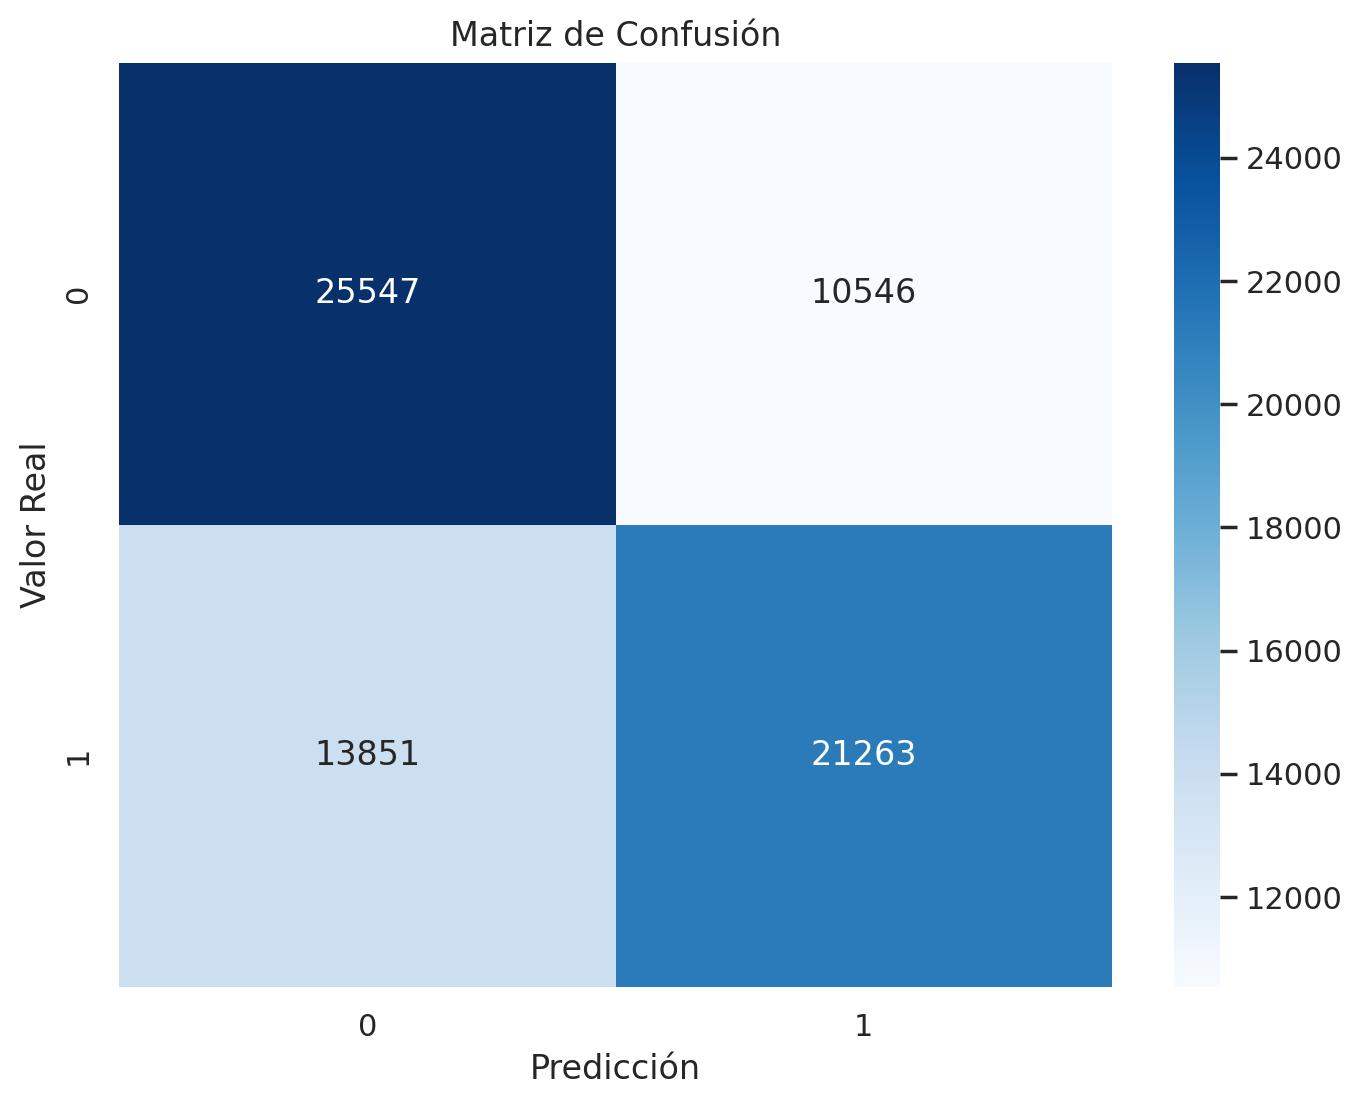

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Entrenamiento con validación cruzada k=10

In [ ]:

# Inicializar listas para almacenar métricas
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Crear un objeto StratifiedKFold para dividir los datos en k-folds estratificados
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Dividir los datos en k-folds y realizar la validación cruzada
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Crear un modelo de Regresión Logística
    model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=42)
    # Entrenar el modelo en los datos de entrenamiento transformados por LDA
    model.fit(X_train_fold, y_train_fold)

    # Predecir las etiquetas en el conjunto de entrenamiento y validación
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)

    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_precision = precision_score(y_train_fold, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_fold, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train_fold, y_train_pred, average='weighted')

    # Calcular métricas de validación
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    val_precision = precision_score(y_val_fold, y_val_pred, average='weighted')
    val_recall = recall_score(y_val_fold, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

    # Almacenar las métricas en las listas
    train_accuracy_scores.append(train_accuracy)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)
    train_f1_scores.append(train_f1)

    val_accuracy_scores.append(val_accuracy)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    val_f1_scores.append(val_f1)

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")

Métricas de entrenamiento promediadas:
Exactitud: 65.69%
Precisión: 65.74%
Recuperación: 65.69%
Puntuación F1: 65.61%

Métricas de validación promediadas:
Exactitud: 65.63%
Precisión: 65.68%
Recuperación: 65.63%
Puntuación F1: 65.55%


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val_fold)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_fold, y_pred_binario)
prop_real = np.sum(y_val_fold)/len(y_val_fold)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_fold)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[5936 2516]
 [3095 5067]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.46


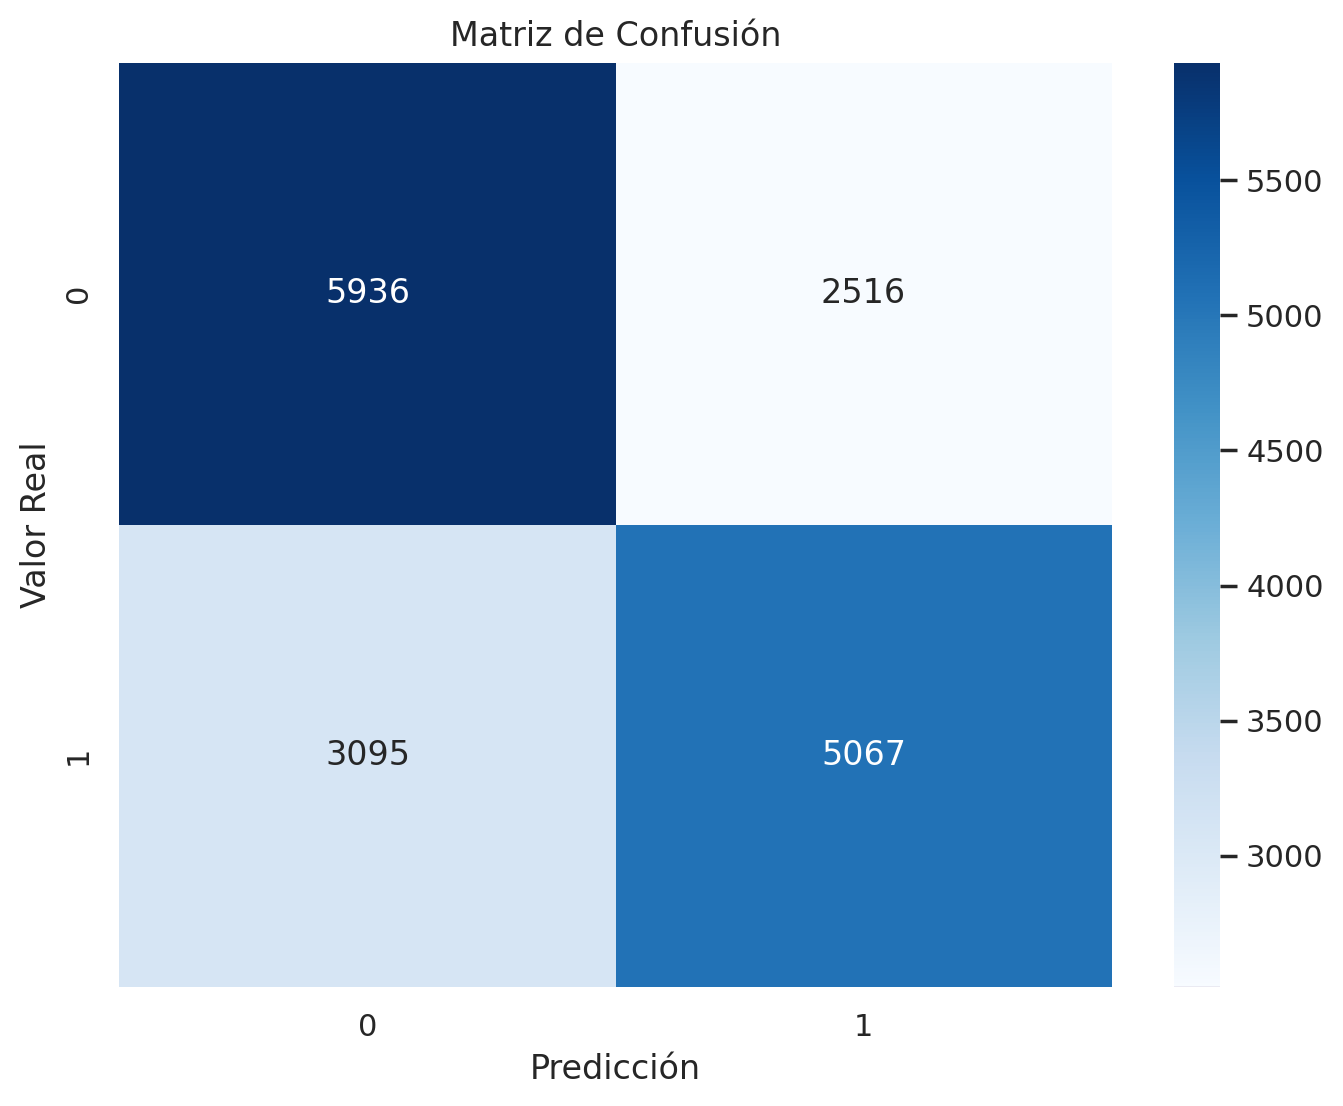

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LIWC/parametros'
model_filename = 'TWEETS_depresón, LIWC y BoW (RN-CV=10).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LIWC/parametros/TWEETS_depresón, LIWC y BoW (RN-CV=10).pkl']